In [1]:
import pandas as pd  # Import pandas for data manipulation and analysis
import numpy as np  # Import NumPy for numerical operations
from sklearn.preprocessing import MinMaxScaler  # Import MinMaxScaler to normalize data for LSTM
from sklearn.metrics import mean_absolute_error  # Import MAE to evaluate model performance
from tensorflow.keras.models import Sequential  # Import Sequential model to build LSTM network
from tensorflow.keras.layers import LSTM, Dense  # Import LSTM and Dense layers for neural network
import matplotlib.pyplot as plt  # Import matplotlib for data visualization

# Load the Air Quality dataset from CSV file into a pandas DataFrame
df = pd.read_csv("/AirQualityUCI.csv")

# Display the first 5 rows of the dataset to inspect structure, column names, and initial values
df.head()


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,03/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,03/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,03/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,03/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,03/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [2]:
# Select only the relevant columns: Date, Time, and CO(GT) for modeling
df = df[['Date', 'Time', 'CO(GT)']]

# Display the first 5 rows to verify that only the selected columns remain
df.head()

,Date,Time,CO(GT)
0,03/10/2004,18:00:00,2.6
1,03/10/2004,19:00:00,2.0
2,03/10/2004,20:00:00,2.2
3,03/10/2004,21:00:00,2.2
4,03/10/2004,22:00:00,1.6


In [3]:
# Replace invalid CO(GT) values (-200) with NaN for proper handling
df['CO(GT)'] = df['CO(GT)'].replace(-200, np.nan)

# Drop all rows with missing values to clean the dataset
df = df.dropna()

In [4]:
# Combine 'Date' and 'Time' columns into a single datetime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Sort the dataset by datetime to maintain chronological order for time series modeling
df = df.sort_values('DateTime')

# Keep only 'DateTime' and 'CO(GT)' columns, removing original 'Date' and 'Time'
df = df[['DateTime', 'CO(GT)']]

# Display the first 5 rows to verify datetime creation and sorting
df.head()


,DateTime,CO(GT)
0,2004-03-10 18:00:00,2.6
1,2004-03-10 19:00:00,2.0
2,2004-03-10 20:00:00,2.2
3,2004-03-10 21:00:00,2.2
4,2004-03-10 22:00:00,1.6


In [5]:
# Extract CO(GT) values as a 2D array for scaling
values = df[['CO(GT)']].values

# Initialize MinMaxScaler to scale CO values between 0 and 1 for LSTM
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
values_scaled = scaler.fit_transform(values)

# Display scaled CO values
values_scaled


array([[0.21186441],
       [0.16101695],
       [0.1779661 ],
       ...,
       [0.19491525],
       [0.16949153],
       [0.1779661 ]])

In [6]:
# Function to create input-output sequences for LSTM
# 'window' defines how many previous time steps to use as input
def create_sequences(data, window=3):
    X, y = [], []  # Initialize empty lists for features (X) and targets (y)
    for i in range(window, len(data)):  # Loop through data starting from 'window' index
        X.append(data[i-window:i])  # Take previous 'window' values as input
        y.append(data[i])  # Current value is the target
    return np.array(X), np.array(y)  # Convert lists to NumPy arrays for model input

# Create sequences with a window size of 3 (using 3 previous CO values to predict next)
X, y = create_sequences(values_scaled, window=3)

# Display the shapes of input and target arrays
print(X.shape)  # (num_samples, window, 1) → LSTM expects 3D input
print(y.shape)  # (num_samples, 1) → corresponding targets


(7671, 3, 1)
(7671, 1)


In [7]:
from sklearn.model_selection import train_test_split  # Import function to split data into training and testing sets

# Split sequences into training and testing sets
# test_size=0.2 → 20% of data is for testing
# shuffle=False → maintain chronological order for time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [8]:
from tensorflow.keras.models import Sequential  # Import Sequential model to build LSTM network
from tensorflow.keras.layers import LSTM, Dense  # Import LSTM and Dense layers

# Create an LSTM model
model = Sequential([
    LSTM(100, activation='tanh', input_shape=(3, 1)),  # LSTM layer with 100 units, tanh activation, input shape = (window size, features)
    Dense(1)  # Output layer with 1 neuron to predict next CO value
])

# Compile the model with Adam optimizer and mean squared error loss
model.compile(
    optimizer='adam',  # Adaptive optimizer for faster convergence
    loss='mse'         # Mean Squared Error loss suitable for regression
)

# Display the model summary: layers, output shapes, number of parameters
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the LSTM model on the training data
history = model.fit(
    X_train, y_train,                # Training input sequences and corresponding targets
    epochs=50,                        # Number of times the model will iterate over the entire training data
    batch_size=32,                    # Number of samples per gradient update
    validation_data=(X_test, y_test)  # Evaluate model performance on test set after each epoch
)



Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0145 - val_loss: 0.0077
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - val_loss: 0.0048
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051 - val_loss: 0.0041
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 12/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

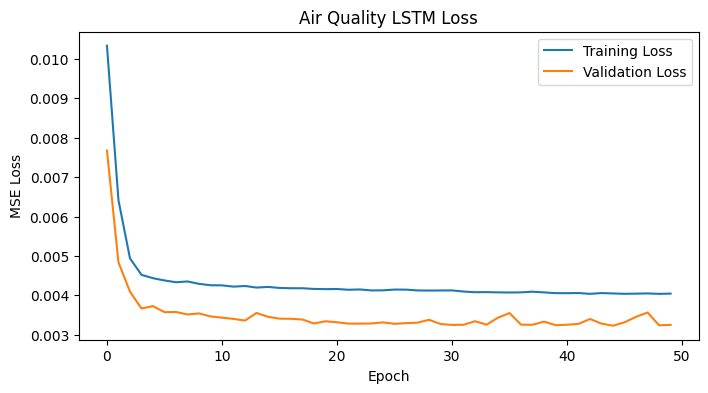

In [10]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Create a figure for the training and validation loss plot
plt.figure(figsize=(8,4))

# Plot training loss (MSE) over epochs
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss (MSE) over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')

# Label x-axis as epochs
plt.xlabel('Epoch')

# Label y-axis as MSE loss
plt.ylabel('MSE Loss')

# Set title for the plot
plt.title('Air Quality LSTM Loss')

# Display legend to differentiate training and validation loss
plt.legend()

# Show the plot
plt.show()

In [11]:
from sklearn.metrics import mean_absolute_error  # Import MAE to evaluate model prediction accuracy

# Predict CO values on test sequences using the trained LSTM model
y_pred = model.predict(X_test)

# Inverse transform predicted values to original CO scale
y_pred_inv = scaler.inverse_transform(y_pred)

# Inverse transform actual test targets to original CO scale
y_test_inv = scaler.inverse_transform(y_test)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [12]:
from sklearn.metrics import mean_absolute_error  # Import MAE metric to evaluate prediction error

# Calculate Mean Absolute Error between actual and predicted CO values
mae = mean_absolute_error(y_test_inv, y_pred_inv)

# Print the MAE to assess model performance in original CO units
print("LSTM MAE (CO):", mae)


LSTM MAE (CO): 0.45326809453362366


In [13]:
# Take the last 3 scaled CO values from the dataset as input for next-step prediction
last_3 = values_scaled[-3:]

# Reshape to match LSTM input shape (1 sample, 3 time steps, 1 feature)
X_infer = last_3.reshape(1, 3, 1)

# Predict the next CO value using the trained LSTM model
next_scaled = model.predict(X_infer)

# Inverse transform to convert the prediction back to original CO scale
next_value = scaler.inverse_transform(next_scaled)

# Print the predicted next CO(GT) value
print("Predicted next CO(GT) value:", next_value)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Predicted next CO(GT) value: [[2.2164876]]


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict CO values using trained LSTM model
y_pred = model.predict(X_test)

# Inverse transform predicted and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Flatten arrays
y_pred_inv = y_pred_inv.flatten()
y_test_inv = y_test_inv.flatten()

# Function to convert CO values into air-quality categories
def air_quality_category(co):
    if co <= 4.0:
        return "Good"
    elif co <= 10.0:
        return "Moderate"
    else:
        return "Unhealthy"

# Convert actual and predicted values to categories
Y_test_cat = [air_quality_category(co) for co in y_test_inv]
pred_lstm_cat = [air_quality_category(co) for co in y_pred_inv]

# All possible classes
classes = ["Good", "Moderate", "Unhealthy"]

# Classification report
print("LSTM Classification Report")
print(classification_report(Y_test_cat, pred_lstm_cat, labels=classes, zero_division=0))

# Confusion matrix (plain numbers)
cm = confusion_matrix(Y_test_cat, pred_lstm_cat, labels=classes)
print("\nLSTM Confusion Matrix ():")
print(cm)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM Classification Report
              precision    recall  f1-score   support

        Good       0.96      0.98      0.97      1404
    Moderate       0.73      0.61      0.67       131
   Unhealthy       0.00      0.00      0.00         0

    accuracy                           0.95      1535
   macro avg       0.57      0.53      0.55      1535
weighted avg       0.94      0.95      0.95      1535


LSTM Confusion Matrix ():
[[1375   29    0]
 [  51   80    0]
 [   0    0    0]]
